# Práctica de algoritmos de clustering y de asociación
### Autor: Bastián Teixeira

## Datos reales para trabajar


* El archivo **spotify_dataset.csv** contiene un dataset con 42305 canciones Spotify, descritas con 23 características, como el "*danceability*", el "*accousticness*" o el "*loudness*".

* El archivo **labeled_songs.csv** contiene las 23 carácterísticas y el genero correspondiente de 150 canciones.

* El archivo **user_preferences.csv** contiene por cada uno de los 6 usuarios (con indices del 0 al 5), el índice de las canciones del archivo spotify_dataset que le han gustado.

# Objetivos a realizar
* Usar algoritmos para clasificar canciones sin género del spotify_dataset
* Confección de un sistema recomendador de canciones para usuarios.




In [ ]:
#Como target para realizar validación externa se puede usar el género al que pertenecen las canciones

#Importar librerías y cargar los datos




---

Para comenzar a trabajar es necesario importar las librerías necesarias y cargar los datasets. En mi caso los subí a la carpeta content de google colab, dentro de una carpeta llamada data_solemne1.

In [ ]:
# sube (copia) los archivos de disponibles en la pagina del classroom a la carpeta donde estes ejecutando el notebook
# Lectura y visualización de datos.
#imports
import warnings
warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")#Eliminar alertas de librerias obsoletas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics import silhouette_score
#subir datasets, en mi caso los subí a la carpeta content de colab como parte de una carpeta llamada data_solemne1
labeled_songs = pd.read_csv("/content/data_solemne1/labeled_songs.csv", low_memory=False)
copy_labeled = labeled_songs.copy() #Creamos una copia del dataset labeled_songs para apriori
spotify_dataset = pd.read_csv("/content/data_solemne1/spotify_dataset.csv" , low_memory=False)
copy_spotify = spotify_dataset.copy() #Creamos una copia del dataset spotify_dataset para apriori
user_preferences = pd.read_csv("/content/data_solemne1/user_preferences.csv" , low_memory=False)
target_c = 'genre' #vamos a utilizar como columna target a 'genre' del dataset de labeled_songs
types = labeled_songs[target_c].unique() #Almacenamos los tipos únicos encontrados en la target column (Es decir almacenamos los
#tipos de etiquetas únicas en la lista types)

#Algoritmo A: KMeans

#1. Preparar los datos y estandarizar

---

Para llevar a cabo el uso de algoritmos de Machine Learning no supervisado, es necesario quedarnos solamente con datos cuantitativos, así que los que son cualitativos los podemos transformar a númericos por medio de "one-hot encoding", pero tomando en cuenta que en el contexto actual no habría mayor diferencia al incluirlos podemos dejarlos fuera temporalmente.

Si el spotify_dataset tuviera las etiquetas conocidas como en labeled_songs (además de que fueran la misma cantidad de filas) se podría aplicar una separación de datos de entrenamiento y de testeo, para así escalar solamente los datos de entrenamiento y evitar fugas de información en el conjunto de prueba (realista), pero como no es el caso se tiene que usar todo el dataset, estandarizar y posteriormente usar labeled_songs para validar.

In [ ]:
#Separar los datos cualitativos de los cuantitativos para el proceso de machine learning no supervisado (clusterización y asosiación)
#Comprobar tipos de datos en el dataset
spotify_dataset.dtypes

,0
Unnamed: 0.1,int64
song_index,int64
danceability,float64
energy,float64
key,int64
loudness,float64
mode,int64
speechiness,float64
acousticness,float64
instrumentalness,float64


In [ ]:
# Obtener las columnas de tipo cuantitativo
columnas_num = spotify_dataset.select_dtypes(include=['float64', 'int64']).columns
x_spotify = spotify_dataset[columnas_num]#almacenar los datos de las columnas cuantitativas en un dataframe

#Comprobar que data_cuantitativa posee las columnas cuantitativas y su data correspondiente
x_spotify.head() #ahora con este dataframe se puede comenzar el proceso de clusterización

,Unnamed: 0.1,song_index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Unnamed: 0
0,0,0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,124539,4,NaN
1,1,1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,224427,4,NaN
2,2,2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,98821,4,NaN
3,3,3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,123661,3,NaN
4,4,4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,123298,4,NaN


In [ ]:
#Limpieza de valores nulos o Nan
print(x_spotify.isna().sum()) #Así obtenemos si las columnas tienen valores nulos y cuantos son

Unnamed: 0.1            0
song_index              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
duration_ms             0
time_signature          0
Unnamed: 0          21525
dtype: int64


In [ ]:
#dado que en la columna Unnamed: 0 hay más de la mitad de datos Nan, no vale la pena reemplazar por otros datos, así que lo mejor
#es eliminarla completa del dataset_cuantitativo
x_spotify_c = x_spotify.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'song_index'])#Eliminar la columnas que no aportan del dataset
print(x_spotify_c.isna().sum()) #comprobar que ya no hayan valores nulos

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


In [ ]:
#normalizar los datos

scaler = MinMaxScaler()#se usa MinaMaxScaler para realizar la normalización o estandarización de los datos
scaler.fit(x_spotify_c) #en esta línea es scaler (siendo MinMaxScaler) aprende los valores max y min del dataset
#Se aplica el estandarizado por medio de min-max scaling
x_spotify_est = scaler.transform(x_spotify_c)#Se aplica la estandarización de datos a x_train, dejando a cada caracteristica de los datos en un rango entre 0 y 1



In [ ]:
#Crear y entrenar el modelo Kmeans

k = 4 #numero de clusters, para empezar escogemos un número aleatorio en mi caso 4.
kmeans = KMeans(n_clusters = k, random_state = 0, n_init=10)

spotify_dataset['cluster'] = kmeans.fit_predict(x_spotify_est) #.fit() de kmeans se encarga de encontrar los centroides de los clusters de los datos de entrenamiento
print(kmeans.cluster_centers_) #Devuelve los vectores promedio de los k clusters
print(kmeans.labels_) #Devuelve las etiquetas

[[ 5.92018705e-01  8.37115017e-01  6.20755373e-01  7.17690587e-01
  -7.90478794e-14  5.07313551e-02  3.75891488e-02  7.91678626e-01
   2.03453607e-01  2.61766720e-01  5.18056587e-01  3.44128620e-01
   7.43955624e-01]
 [ 6.44165312e-01  7.15422775e-01  4.01283642e-01  7.45454570e-01
   1.00000000e+00  1.67362906e-01  1.25974766e-01  2.92670685e-02
   2.09860967e-01  3.95951066e-01  5.71452783e-01  1.98952994e-01
   7.43241079e-01]
 [ 6.16905292e-01  8.42282510e-01  4.37782752e-01  7.17611234e-01
   1.00000000e+00  5.22191280e-02  3.18511292e-02  7.94440919e-01
   2.08115353e-01  2.68115658e-01  5.05513617e-01  3.56024765e-01
   7.41225773e-01]
 [ 6.13933022e-01  7.33455501e-01  5.58105607e-01  7.47190732e-01
   4.37427872e-14  1.49650566e-01  1.32713523e-01  3.27910974e-02
   2.08331080e-01  3.85716449e-01  5.71826750e-01  2.12816080e-01
   7.43772455e-01]]
[1 1 1 ... 1 3 1]


In [ ]:
x_labels = labeled_songs[columnas_num]
x_labels_c = x_labels.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'song_index'])#Eliminar la columna del dataset
print(x_labels_c.isna().sum()) #comprobar que ya no hayan valores nulos

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


In [ ]:
scaler = MinMaxScaler()#se usa MinaMaxScaler para realizar la normalización o estandarización de los datos
scaler.fit(x_labels_c) #en esta línea es scaler (siendo MinMaxScaler) aprende los valores max y min del dataset
#Se aplica el estandarizado por medio de min-max scaling
x_labels_est = scaler.transform(x_labels_c)#Se aplica la estandarización de datos dejando a cada caracteristica de los datos en un rango entre 0 y 1
labeled_songs['cluster'] = kmeans.predict(x_labels_est)

In [ ]:
# Comparar los datos de los clusters
res = []  # detalle por cluster
r = []    # clase representativa por cluster

for i in range(k):#Este ciclo va repetirse por cada cluster (i) y les crea un diccionario que cuenta el num de ejemplos de cada
# género (g) que pertenece a ese cluster en especifico
    tmp = {g: [0, 0] for g in types}  # ejemplo de como es visualmente: {genero: [conteo, x]}
    res.append(tmp)#Almacenar almacena el diccionario del cluster en res

# Contar cuántos ejemplos de cada género cayeron en cada cluster
for i in range(len(labeled_songs)):
    cluster_id = labeled_songs.iloc[i]['cluster']
    genre = labeled_songs.iloc[i]['genre']
    res[cluster_id][genre][0] += 1

# Determinar clase mayoritaria de cada cluster
for i in range(k):
    max_count = 0
    major_class = None
    for g in types:
        if res[i][g][0] > max_count:
            max_count = res[i][g][0]
            major_class = g
    r.append(major_class)  # clase más frecuente para cluster i

print("Clase representativa de cada cluster:", r)


Clase representativa de cada cluster: ['techhouse', 'Trap Metal', 'techno', 'hardstyle']


In [ ]:
# Crear un diccionario donde se asigne el cluster -> genero
cluster_genre = {i: r[i] for i in range(k)}

# Aplicar al dataset completo
spotify_dataset['pred_genre'] = spotify_dataset['cluster'].map(cluster_genre)


In [ ]:
#Revisar como quedó en el dataset de spotify
spotify_dataset.head(10)

,Unnamed: 0.1,song_index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,Unnamed: 0,title,cluster,pred_genre
0,0,0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,...,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Mercury: Retrograde,NaN,NaN,1,Trap Metal
1,1,1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,...,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Pathology,NaN,NaN,1,Trap Metal
2,2,2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,...,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Symbiote,NaN,NaN,1,Trap Metal
3,3,3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,...,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN,1,Trap Metal
4,4,4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,...,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Venom,NaN,NaN,1,Trap Metal
5,5,5,0.721,0.568,0,-11.295,1,0.4140,0.0452,0.212000,...,spotify:track:6fsypiJHyWmeINsOLC1cos,https://api.spotify.com/v1/tracks/6fsypiJHyWme...,https://api.spotify.com/v1/audio-analysis/6fsy...,112511,4,Gatteka,NaN,NaN,1,Trap Metal
6,6,6,0.718,0.668,8,-4.162,1,0.1370,0.0254,0.007800,...,spotify:track:0XfQbq7DaMOmVXgQ71eA6E,https://api.spotify.com/v1/tracks/0XfQbq7DaMOm...,https://api.spotify.com/v1/audio-analysis/0XfQ...,77584,4,kamikaze (+ pulse),NaN,NaN,1,Trap Metal
7,7,7,0.694,0.711,8,-5.525,1,0.2210,0.0397,0.000000,...,spotify:track:0LLeuNBWPOg3XA73yab3PT,https://api.spotify.com/v1/tracks/0LLeuNBWPOg3...,https://api.spotify.com/v1/audio-analysis/0LLe...,127524,3,T.R.U. (Totally Rotten Underground),NaN,NaN,1,Trap Metal
8,8,8,0.774,0.751,1,-2.445,1,0.1980,0.0614,0.000000,...,spotify:track:37gqBnUAZe8BY8WR56kDNk,https://api.spotify.com/v1/tracks/37gqBnUAZe8B...,https://api.spotify.com/v1/audio-analysis/37gq...,140326,4,I Put My Dick in Your Mental,NaN,NaN,1,Trap Metal
9,9,9,0.893,0.907,11,-10.406,1,0.3670,0.1520,0.031100,...,spotify:track:2ggqfj97qyiORmXoVFzP5j,https://api.spotify.com/v1/tracks/2ggqfj97qyiO...,https://api.spotify.com/v1/audio-analysis/2ggq...,121979,4,Andromeda,NaN,NaN,1,Trap Metal


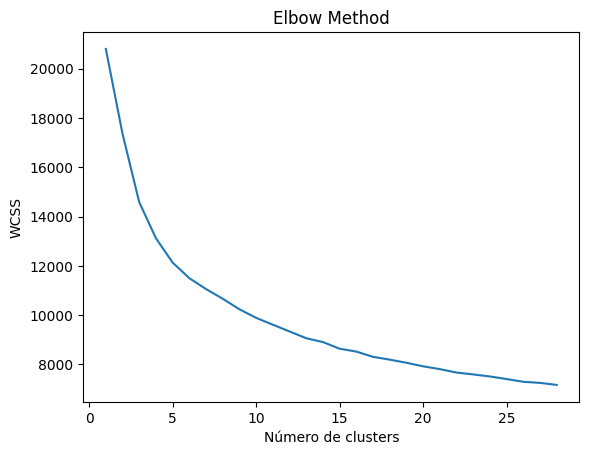

In [ ]:
#Escoger la mejor k con el método del codo (elbow method)
#el rango recomendado para probar los k va de 30 a 40 clusters para datasets no tan pequeños, pero igual se puede ir probando
wcss = [] #elbow method para encontrar el mejor num de clusters (validación interna)

# Calculate WCSS for a range of k values
for k in range(2,30,1):#number of clusters
    kmeans = KMeans(n_clusters = k, random_state = 0, n_init=10) #se vuelve a entrenar al kmeans para probar con múltiples números de clusters hasta encontrar el número
    #que devuela la mayor precisión de clasificación correcta
    kmeans.fit(x_spotify_est)
    wcss.append(kmeans.inertia_) #por inertia


#esto permite encontrar el punto de quiebre (num de clusters) donde a partir de ahí el valor no es muy relevante o aporta mucho para la precisión
#Especialmente útil cuando no conocemos las etiquetas, como en este caso.
plt.plot(range(1, k), wcss)
plt.title('Elbow Method')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
#A partir de esto podemos indentificar que el punto de quiebre se forma entre los 4 y 6 clusters.
k= 5 #número de clusters óptimo obtenido por elbow method
kmeans = KMeans(n_clusters = k, random_state = 0, n_init=10)

spotify_dataset['cluster'] = kmeans.fit_predict(x_spotify_est) #.fit() de kmeans se encarga de encontrar los centroides de los clusters de los datos de entrenamiento

scaler = MinMaxScaler()#se usa MinaMaxScaler para realizar la normalización o estandarización de los datos
scaler.fit(x_labels_c) #en esta línea es scaler (siendo MinMaxScaler) aprende los valores max y min del dataset
#Se aplica el estandarizado por medio de min-max scaling
x_labels_est = scaler.transform(x_labels_c)#Se aplica la estandarización de datos dejando a cada caracteristica de los datos en un rango entre 0 y 1
labeled_songs['cluster'] = kmeans.predict(x_labels_est)

res = []  # detalle por cluster
r = []    # clase representativa por cluster

for i in range(k):#Este ciclo va repetirse por cada cluster (i) y les crea un diccionario que cuenta el num de ejemplos de cada
# género (g) que pertenece a ese cluster en especifico
    tmp = {g: [0, 0] for g in types}  # ejemplo de como es visualmente: {genero: [conteo, x]}
    res.append(tmp)#Almacenar almacena el diccionario del cluster en res

# Contar cuántos ejemplos de cada género cayeron en cada cluster
for i in range(len(labeled_songs)):
    cluster_id = labeled_songs.iloc[i]['cluster']
    genre = labeled_songs.iloc[i]['genre']
    res[cluster_id][genre][0] += 1

# Determinar clase mayoritaria de cada cluster
for i in range(k):
    max_count = 0
    major_class = None
    for g in types:
        if res[i][g][0] > max_count:
            max_count = res[i][g][0]
            major_class = g
    r.append(major_class)  # clase más frecuente para cluster i

cluster_genre = {i: r[i] for i in range(k)}
print("Clase representativa de cada cluster:", r)
# Aplicar al dataset completo
spotify_dataset['pred_genre'] = spotify_dataset['cluster'].map(cluster_genre)


Clase representativa de cada cluster: ['hardstyle', 'techno', 'Emo', 'Underground Rap', 'techhouse']


In [ ]:
#Revisar dataset de spotify
spotify_dataset.head(5)

,Unnamed: 0.1,song_index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,uri,track_href,analysis_url,duration_ms,time_signature,song_name,Unnamed: 0,title,cluster,pred_genre
0,0,0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,...,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Mercury: Retrograde,NaN,NaN,3,Underground Rap
1,1,1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,...,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Pathology,NaN,NaN,2,Emo
2,2,2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,...,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Symbiote,NaN,NaN,2,Emo
3,3,3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,...,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN,3,Underground Rap
4,4,4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,...,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Venom,NaN,NaN,3,Underground Rap


#Algoritmo B: Apriori

In [ ]:
# Copiar datos de canciones etiquetadas
df = copy_labeled #A partir de aquí vamos a estar trabajando con una copia del dataset original
#Eliminar columnas que no aportan al entrenamiento de apriori
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'song_index','type','id','uri','track_href','analysis_url','title','song_name'])

# No tomar las variables que NO son continuas o númericas, tales como genrey definirlas como categoricas
df['genre'] = df['genre'].astype(str)
df['genre'] = df['genre'].astype('category')

# Seleccionar solo columnas numéricas
numcols = df.select_dtypes(['number'])
#Estandarizar todas las columnas númericas
for i in numcols:
    df[i] = (df[i]-(0.999*df[i].min()))/((1.001*df[i].max())-(0.999*df[i].min()))

#revisar valores nulos
print(df.isna().sum())

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
genre               0
dtype: int64


In [ ]:
# Hacer binning

bins = [0, 0.25, 0.50, 0.75, 1.0]#generar rango (bins), probé dividiendo en 5 tipo de variables (incluyendo 0 y 1.0)

for i in numcols: #Este ciclo va a "transformar" las variables continuas en categoricas acorde a los bins definidos
    labels = [i+'[0,25]',i+'(25,50]',i+'(50,75]',i+'(75,100]']#bin ids
    print(labels)
    df[i] = pd.cut(df[i], bins=bins, labels=labels, include_lowest=True, right=True) #Incluimos al 0 con include_lowest=True e incluimos el 1.0 con right=True
df.info() #La idea de incluir estos valores es para no excluir algunas categorías y así no quedar con menos que podrían provocar que la asignación sea muy génerica
print(df.isna().sum()) #Comprobar valores nulos después del binning

['danceability[0,25]', 'danceability(25,50]', 'danceability(50,75]', 'danceability(75,100]']
['energy[0,25]', 'energy(25,50]', 'energy(50,75]', 'energy(75,100]']
['key[0,25]', 'key(25,50]', 'key(50,75]', 'key(75,100]']
['loudness[0,25]', 'loudness(25,50]', 'loudness(50,75]', 'loudness(75,100]']
['mode[0,25]', 'mode(25,50]', 'mode(50,75]', 'mode(75,100]']
['speechiness[0,25]', 'speechiness(25,50]', 'speechiness(50,75]', 'speechiness(75,100]']
['acousticness[0,25]', 'acousticness(25,50]', 'acousticness(50,75]', 'acousticness(75,100]']
['instrumentalness[0,25]', 'instrumentalness(25,50]', 'instrumentalness(50,75]', 'instrumentalness(75,100]']
['liveness[0,25]', 'liveness(25,50]', 'liveness(50,75]', 'liveness(75,100]']
['valence[0,25]', 'valence(25,50]', 'valence(50,75]', 'valence(75,100]']
['tempo[0,25]', 'tempo(25,50]', 'tempo(50,75]', 'tempo(75,100]']
['duration_ms[0,25]', 'duration_ms(25,50]', 'duration_ms(50,75]', 'duration_ms(75,100]']
['time_signature[0,25]', 'time_signature(25,50]'

In [ ]:
#Preparar datos para que sean válidos para Apriori (convertirlos en "booleanos"), este pedazo de código lo reutilicé de los notebooks trabajados en clase
my_df = pd.DataFrame()
#Este loop itera por cada columna y su valores únicos (categorías) del df, para cada una de estas últimas se crea como una nueva columna en my_df
#con valores booleanos que indican si la categoría está presenta en cada fila
for i in df:
    for j in df[i].unique():
        l = []
        for r in range(len(df)):
            if df[i][r] == j:
                l.append(True)
            else:
                l.append(False)
        my_df[j] = l
print(my_df)

     danceability(50,75]  danceability(25,50]  danceability(75,100]  \
0                   True                False                 False   
1                  False                 True                 False   
2                   True                False                 False   
3                  False                False                  True   
4                  False                False                  True   
..                   ...                  ...                   ...   
145                False                 True                 False   
146                 True                False                 False   
147                False                 True                 False   
148                False                 True                 False   
149                False                False                 False   

     danceability[0,25]  energy(50,75]  energy(75,100]  energy(25,50]  \
0                 False           True           False          False   
1

In [ ]:
# Aplicar Apriori
frequent_itemsets = apriori(my_df, min_support=0.02, use_colnames=True)#calcular los itemsets frecuentes (presentes en almenos
#el 2% de las canciones)
print("Itemsets Frecuentes con Apriori:")
print(frequent_itemsets)
#Generar las reglas de asociación en base a los itemsets frecuentes con un 50% de confianza mínimo
rules = association_rules(frequent_itemsets, metric="confidence",  min_threshold = 0.5)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)
#Se prueba con diferentes min_support (%de presencia de un item en las canciones) y min_threshold (% min de confianza de las reglas)
#para que así no se filtren de más los datos y se termine teniendo un solo tipo de dato a mayor confianza y lift



Itemsets Frecuentes con Apriori:
         support                                           itemsets
0       0.413333                              (danceability(50,75])
1       0.286667                              (danceability(25,50])
2       0.266667                             (danceability(75,100])
3       0.033333                               (danceability[0,25])
4       0.286667                                    (energy(50,75])
...          ...                                                ...
126505  0.020000  (energy(75,100], duration_ms(25,50], liveness(...
126506  0.020000  (duration_ms(25,50], loudness(75,100], livenes...
126507  0.020000  (tempo(25,50], liveness[0,25], trance, energy(...
126508  0.026667  (energy(75,100], duration_ms(25,50], loudness(...
126509  0.020000  (energy(75,100], duration_ms(25,50], loudness(...

[126510 rows x 2 columns]


,antecedents,consequents,support,confidence,lift
0,"(danceability(50,75])","(energy(75,100])",0.280000,0.677419,1.154692
1,"(key(25,50])","(danceability(50,75])",0.080000,0.521739,1.262272
2,"(danceability(50,75])","(loudness(75,100])",0.326667,0.790323,1.107929
3,"(danceability(50,75])","(mode(75,100])",0.220000,0.532258,1.078901
4,"(danceability(50,75])","(speechiness[0,25])",0.346667,0.838710,1.048387
5,"(danceability(50,75])","(acousticness[0,25])",0.366667,0.887097,1.047752
6,"(acousticness(25,50])","(danceability(50,75])",0.033333,0.500000,1.209677
7,"(danceability(50,75])","(instrumentalness[0,25])",0.260000,0.629032,0.962804
8,"(instrumentalness(25,50])","(danceability(50,75])",0.026667,0.800000,1.935484
9,"(liveness(25,50])","(danceability(50,75])",0.113333,0.515152,1.246334


In [ ]:
# Filtrar reglas de tal forma que los géneros sean "consequents"
genres = df['genre'].unique().tolist() #convertimos cada "género" encontrado para almacenarlos de forma única en la lista
#EJ: ['pop','rock',...]
#Para poder asignar los géneros al spotify_dataset, ordenamos las reglas para filtrar aquellas que tengan como consecuente un género
rules_genre = rules[rules['consequents'].apply(lambda x: any(g in x for g in genres) and len(x) == 1)]
#"g"navega como un loop interno en la línea, donde toma los valores de cada item (género) en la lista de generos
#El loop externo en la línea navega cada elemento en los 'consequents' (x), y por cada uno se queda con aquellos que se encuentren
#en la lista de "genres" (g in genres) y al mismo tiempo en 'consequents' (g in x)
#Así finalmente se pueden filtrar las reglas para quedarse con aquellas que tienen 'consequent' un solo género

# Ordenar por confianza y lift (para quedarse con las más fuertes primero)
rules_genre = rules_genre.sort_values(by=['confidence','lift'], ascending=False)
#Comprobamos las nuevas reglas del set
rules_genre[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
1769,"(danceability(25,50], duration_ms(75,100])",(psytrance),0.020000,1.0,15.0
4579,"(duration_ms(75,100], key(50,75])",(psytrance),0.020000,1.0,15.0
8852,"(tempo(75,100], instrumentalness(75,100])",(dnb),0.020000,1.0,15.0
20066,"(danceability(25,50], duration_ms(75,100], spe...",(psytrance),0.020000,1.0,15.0
20476,"(danceability(25,50], duration_ms(75,100], aco...",(psytrance),0.020000,1.0,15.0
20767,"(danceability(25,50], duration_ms(75,100], ins...",(psytrance),0.020000,1.0,15.0
20845,"(danceability(25,50], tempo(50,75], liveness(2...",(hardstyle),0.033333,1.0,15.0
20988,"(liveness[0,25], danceability(25,50], duration...",(psytrance),0.020000,1.0,15.0
25679,"(duration_ms(25,50], danceability(75,100], ins...",(techhouse),0.020000,1.0,15.0
27889,"(mode(75,100], duration_ms(50,75], energy(50,75])",(techno),0.020000,1.0,15.0


In [ ]:
#Realizar binning también al copy_spotify
spotify_bin = copy_spotify
print(spotify_bin.isna().sum())

Unnamed: 0.1            0
song_index              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
type                    0
id                      0
uri                     0
track_href              0
analysis_url            0
duration_ms             0
time_signature          0
song_name           20786
Unnamed: 0          21525
title               21525
dtype: int64


In [ ]:
#Realizar binning también al copy_spotify
spotify_bin = copy_spotify
spotify_bin = spotify_bin.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'song_index','type','id','uri','track_href','analysis_url','title','song_name'])
#Marcar como categoricas a las columnas key y mode
spotify_bin['key'] = spotify_bin['key'].astype('category')
spotify_bin['mode'] = spotify_bin['mode'].astype('category')

# Seleccionar solo columnas numéricas
numcols = spotify_bin.select_dtypes(['number'])
#Estandarizar todas las columnas númericas
for i in numcols:
    spotify_bin[i] = (spotify_bin[i]-(0.999*spotify_bin[i].min()))/((1.001*spotify_bin[i].max())-(0.999*spotify_bin[i].min()))

#Realizar Binning
#Usando el mismo rango (bins) que se usó para el binning de copy_labels
for i in numcols:
    labels = [i+'[0,25]',i+'(25,50]',i+'(50,75]',i+'(75,100]']#bin ids
    print(labels)
    spotify_bin[i] = pd.cut(spotify_bin[i], bins=bins, labels=labels, include_lowest=True, right=True)

print(spotify_bin.isna().sum())

['danceability[0,25]', 'danceability(25,50]', 'danceability(50,75]', 'danceability(75,100]']
['energy[0,25]', 'energy(25,50]', 'energy(50,75]', 'energy(75,100]']
['loudness[0,25]', 'loudness(25,50]', 'loudness(50,75]', 'loudness(75,100]']
['speechiness[0,25]', 'speechiness(25,50]', 'speechiness(50,75]', 'speechiness(75,100]']
['acousticness[0,25]', 'acousticness(25,50]', 'acousticness(50,75]', 'acousticness(75,100]']
['instrumentalness[0,25]', 'instrumentalness(25,50]', 'instrumentalness(50,75]', 'instrumentalness(75,100]']
['liveness[0,25]', 'liveness(25,50]', 'liveness(50,75]', 'liveness(75,100]']
['valence[0,25]', 'valence(25,50]', 'valence(50,75]', 'valence(75,100]']
['tempo[0,25]', 'tempo(25,50]', 'tempo(50,75]', 'tempo(75,100]']
['duration_ms[0,25]', 'duration_ms(25,50]', 'duration_ms(50,75]', 'duration_ms(75,100]']
['time_signature[0,25]', 'time_signature(25,50]', 'time_signature(50,75]', 'time_signature(75,100]']
danceability        0
energy              0
key                 0

In [ ]:
# Preparar los datos de spotify_bin igual que my_df para que sirvan para Apriori(Transformar en datos booleanos)
#Este loop itera por cada columna y su valores únicos (categorías) del df, para cada una de estas últimas se crea como una nueva columna en my_df
#con valores booleanos que indican si la categoría está presenta en cada fila
spotify_bool = pd.DataFrame()
for i in spotify_bin:
    for j in spotify_bin[i].unique():
        l = []
        for r in range(len(spotify_bin)):
            l.append(spotify_bin[i].iloc[r] == j)
        spotify_bool[j] = l

spotify_bool['pred_genre'] = "Unknown" #Asignar de forma predeterminada los datos en la columna 'pred_genre' como "Unkown"

In [ ]:
#Asignar el género a las canciones del dataset de spotify
for index, rule in rules_genre.iterrows(): #Se recorre cada fila de las reglas generadas (rules_genre)
    #Se separan y almacenan los antecedentes y predicciones en listas separadas
    antecedentes = list(rule['antecedents'])
    predicciones = list(rule['consequents'])[0]

    mask = spotify_bool['pred_genre'].eq("Unknown") #Generamos una máscara para todos las filas de spotify_bool que no tienen género (marcadas como Unknown)
    #Luego se pueden ir agregando categorías a las canciones
    for ant in antecedentes:
        if ant in spotify_bool.columns:#Comprobar que el antecedente existe en las columnas de spotify_bool
            mask &= spotify_bool[ant]# usar la columna booleana para marcar como True solo si ya era antes True, e ir así actualizando la máscara
    # asignar el género
    spotify_bool.loc[mask, 'pred_genre'] = predicciones #bajo las condiciones de la mascara (donde las filas de esta sean True) se actualiza la columna 'pred_genre'
    #con la predicción, es decir donde la canción coincide con los antecedentes y no tiene un género asignado se le asigna como género el "consequent" (la predicción)

In [ ]:
#Comprobar la asignación de géneros para las canciones
spotify_bool.head(20)

,"danceability(75,100]","danceability(50,75]","danceability(25,50]","danceability[0,25]","energy(75,100]","energy(25,50]","energy(50,75]","energy[0,25]",2,8,...,"tempo[0,25]","duration_ms[0,25]","duration_ms(25,50]","duration_ms(50,75]","duration_ms(75,100]","time_signature(50,75]","time_signature(25,50]","time_signature(75,100]","time_signature[0,25]",pred_genre
0,True,False,False,False,True,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,techno
1,False,True,False,False,False,True,False,False,False,True,...,False,True,False,False,False,True,False,False,False,techno
2,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,dnb
3,False,False,True,False,True,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,dnb
4,True,False,False,False,False,False,True,False,True,False,...,False,True,False,False,False,True,False,False,False,RnB
5,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,techno
6,False,True,False,False,False,False,True,False,False,True,...,False,True,False,False,False,True,False,False,False,techno
7,False,True,False,False,False,False,True,False,False,True,...,False,True,False,False,False,False,True,False,False,RnB
8,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,dnb
9,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,dnb


#Comparación entre los algoritmos utilizados
---

A simple vista se nota una diferencia con los resultados de la asignación de cada algoritmo.

Por un lado con el Clustering llevado a cabo con Kmeans fue posible realizar una "categorización" mediante la creación de clusters para el dataset labeled_songs un número óptimo de 5 clusters (Clase representativa de cada cluster: ['hardstyle', 'techno', 'Emo', 'Underground Rap', 'techhouse']). Bajo esta metodología se pudieron clasificar las canciones del spotify_dataset con la integración de dos nuevas columnas:
* 'cluster' que indica el número del cluster al que pertenece la canción.
* 'pred_genre' que muestra el género representante del mismo.

Este algoritmo se mostró relativamente simple y no muy costoso, ya que lo que más tiempo tomó procesar fue el método del codo para encontrar el número eficiente de clusters (k).

Ahora con el algoritmo de Asosiación Apriori, se pudo clasificar las canciones bajo un set de reglas que se crearon en base a las caracteristicas (adaptadas como booleanas) del dataset labeled_songs. Es con esto que finalmente las canciones del spotify_dataset fueron categorizadas. Si bien se nota una mayor variedad de géneros a diferencia de las generadas con Kmeans, las limitaciones que posee el algoritmo recaen en los filtros para generar las reglas, como el proceso de binning y la selección de los umbrales de % de confianza o lift.

También Apriori parece ser más costoso que Kmeans, ya que al momento de generar las reglas o asignarlas al dataset de spotify, hubo un tiempo de procesamiento mucho más extenso (por ejemplo, en la asignación de géneros se alcanzaban unos 3 minutos).

Ambos algoritmos parecen cumplir con la tarea designada, pero creo que algoritmos de asociación como Apriori parecen ser más adecuados para llevar a cabo procesos de categorización como este.

#Recomendar 10 canciones para cada usuario
---

Para llevar a cabo este punto en la tarea, decidí usar el dataset clasificado por Kmeans para utilizar como potenciales canciones para recomendar. Esto debido a que la forma que se me ocurrió para recomendar canciones es en base a los clusters en las que están "categorizadas", es decir a partir de las canciones que le gustan a un usuario x, se puede determinar a que clusters pertenecen dentro del dataset y así encontrar un cluster preferido para sacar canciones que le puedan gustar.

Otra razón es que a diferencia de Apriori, los datos del dataset siguen siendo interpretables (no booleanos) por lo que es un proceso más simple de llevar a cabo.

In [ ]:
# inicializar recomendaciones con el dataset de spotify clasificado por Kmeans
recomendaciones = {} #Diccionario donde se van a almacenar las recomendaciones
# Group liked songs by user ID
user_preferences.columns = ['id_usuario', 'id_cancion'] # Renombramos los nombres de las columnas para que sea más claro el trabajar
#Vamos a agrupar las preferencias del usuario por el 'user_id' para que las canciones que les gustaron queden juntas en una lista
user_group = user_preferences.groupby('id_usuario')['id_cancion'].apply(list)
#De esta forma en lugar de tener por fila un "id" del usuario y de la canción que le gustó, se va a tener algo como
# 0: [123,456,789], así quedan las canciones que le gustaban al usuario 0 agrupadas por id_usuario
#Este ciclo recorre por fila las preferencias de usuario agrupadas, para posteriormente identificar un cluster parecido al de las
#Canciones que le gustan
for idUsuario, likes_canci in user_group.items():
    #almacenar los cluster que contienen las canciones que le gustan al usuario
    likes_clusters = spotify_dataset.loc[spotify_dataset['song_index'].isin(likes_canci), 'cluster']

    #Obtener el cluster favorito (más repetido acorde a las canciones que le gustan) del usuario
    cluster_top = likes_clusters.value_counts().idxmax() #Lo obtenemos con idxmax y lo almacenamos en cluster_top
    #Recomendar 10 canciones del mismo cluster favorito y que no estén en su lista.
    #Almacenamos las canciones en recomendaciones por idUsuario
    recomendaciones[idUsuario] = (spotify_dataset[(spotify_dataset['cluster'] == cluster_top) & (~spotify_dataset['song_index'].isin(likes_canci))].sample(10))
    #Con .sample podemos obtener una muestra aleatoria de 10 elementos dentro del dataset (y que pertenezcan al cluster fav)
#Finalmente visualizamos las recomendaciones finales
#Cabe recalcar que como se escogen al azar dentro de cada cluster favorito, es probable que por cada ejecución los resultados cambien
for i in range(6):
    print(f"Recomendaciones para el usuario {i}:\n", recomendaciones[i][['song_index','song_name','pred_genre']])

Recomendaciones para el usuario 0:
        song_index                                     song_name pred_genre
28642       28642                                           NaN  hardstyle
19625       19625                    Again (feat. XXXTENTACION)  hardstyle
13392       13392                           Talking to the Moon  hardstyle
39152       39152                                           NaN  hardstyle
4353         4353                       Arcadia - Heimanu Remix  hardstyle
17044       17044                Butterflies Pt. 2 - Wale Remix  hardstyle
8987         8987                              Lion King On Ice  hardstyle
20060       20060                               Let Yourself Go  hardstyle
617           617                      Aw Shit - Zillakami Solo  hardstyle
10708       10708  Adult Swim (Feat. Original God & Yung Bitch)  hardstyle
Recomendaciones para el usuario 1:
        song_index song_name pred_genre
23279       23279       NaN     techno
22086       22086       N

##¿Cambian las recomendaciones según el algoritmo usado?

La respuesta es si, ambos algoritmos tienen una forma diferente de categorizar las canciones del dataset, por lo que se obtuvieron resultados distintos. Kmeans mantiene una categorización con 5 categorías (o el num de clusters que se le defina), mientras que Apriori lo determina en base a las reglas generadas y el nivel de confianza y lift que haya en cada una. Por lo que es claro que al momento recomendar canciones, tanto los procesos para realizarlo como los resultados serían diferentes. (Yo por ejemplo lo hice mediante una asosiación con el cluster "favorito" de cada usuario, pero con Apriori no es posible hacerlo de esa manera)

#Cambio de metodología para encontrar el número óptimo de clusters

---

Ya se determinó el número óptimo de clusters mediante el método del codo, pero ahora se va a realizar con el coeficiente de silueta (Silhouette coefficient).

Silohouette coefficient es un método de validación interna que permite obtener un "puntaje" para cada num de clusters, de los cuáles el que más se acerque a 1 es el más óptimo. Básicamente nos permite evaluar que tan bien construidos están los clusters.

In [ ]:
#Se usa silhouette_score de sklearn para calcular los "puntajes"
for k in range(2, 20):#Se crea un loop para probar con diferentes num de clusters
    kmeans = KMeans(n_clusters=k, random_state=42) #volvemos a hacer kmeans
    labels = kmeans.fit_predict(x_spotify_est)
    score = silhouette_score(x_spotify_est, labels) #Se calcular el puntaje en base a que tan bien están construidos los clusters (encontrar num optimo)
    print(f"k={k}, silhouette={score}")

k=2, silhouette=0.3246315018647374
k=3, silhouette=0.23678999011095253
k=4, silhouette=0.25262746347792986
k=5, silhouette=0.272667034117113
k=6, silhouette=0.2424685233994188
k=7, silhouette=0.236877124997688
k=8, silhouette=0.23499219602035323
k=9, silhouette=0.20559019705434062
k=10, silhouette=0.19411623778316517
k=11, silhouette=0.18784791412885132
k=12, silhouette=0.1901770124875152
k=13, silhouette=0.18966291539037206
k=14, silhouette=0.1868197568989684
k=15, silhouette=0.18730764325089197
k=16, silhouette=0.17890336780942673
k=17, silhouette=0.17502549266536915
k=18, silhouette=0.17440798711392805
k=19, silhouette=0.17398854286669058


Con este cambio de metodología se puede observar que de por si los clusters que se construyeron presentan puntajes bajos, no negativos, pero no se acercan a 1. Esto indica que es posible que los clusters estén muy cercanos los unos a los otros o se estén "sobreponiendo", lo que son señales de una clusterización pobre. Aún así el número óptimo de clusters para este caso parece seguir siendo 5, con el mayor puntaje en 20 números diferentes.

Considero que el dataset puede influir también en que tan bien se pueden construir clusters, ya que intentar realizar clusterización de datos como son los de las canciones se pueden parecer mucho los uno a los otros o pueden poseer varias carecteristicas similiares que provoca que se terminen agrupando de una forma más "general".

Es por esto que en este caso es probable que tanto el método del codo como el del Silhouette Score den resultados similares, pero para otros casos esto puede no siempre ser así, ya que el metodo del codo podría decir que es más "al ojo" mientras que el Silhoutte calcula puntajes en base a las distancias entre los clusters.